<a href="https://colab.research.google.com/github/Heba2424/Water-Segmentation-using-Multispectral-and-optical-Data/blob/main/Water_Segmentation_using_Pretrained_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [1]:
!pip install rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 78.1 MB/s eta 0:00:00


In [2]:
!unzip /content/data-20240901T092540Z-001.zip

Archive:  /content/data-20240901T092540Z-001.zip
  inflating: data/images/288.tif     
  inflating: data/images/279.tif     
  inflating: data/images/297.tif     
  inflating: data/images/298.tif     
  inflating: data/images/300.tif     
  inflating: data/images/293.tif     
  inflating: data/images/282.tif     
  inflating: data/images/2.tif       
  inflating: data/images/278.tif     
  inflating: data/images/285.tif     
  inflating: data/images/296.tif     
  inflating: data/images/291.tif     
  inflating: data/images/301.tif     
  inflating: data/images/292.tif     
  inflating: data/images/295.tif     
  inflating: data/images/274.tif     
  inflating: data/images/302.tif     
  inflating: data/images/266.tif     
  inflating: data/images/294.tif     
  inflating: data/images/303.tif     
  inflating: data/images/284.tif     
  inflating: data/images/290.tif     
  inflating: data/images/281.tif     
  inflating: data/images/299.tif     
  inflating: data/images/283.tif     
 

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [4]:
!pip install segmentation-models-pytorch --quiet
!pip install torchmetrics --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 45.9 MB/s eta 0:00:00


In [5]:
import torch
from torch.utils.data import TensorDataset
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tifffile as tiff
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score as f1_score_sklearn, accuracy_score


In [6]:
# Step 2: Define Dataset Class Using tifffile for .tif images and PIL for .png masks
class TiffPngSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_name = self.images[idx].replace('.tif', '.png')  # Assuming corresponding mask has the same name but .png extension
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = tiff.imread(img_path)
        mask = Image.open(mask_path).convert("L")

        # Convert to 3-channel image if necessary
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)  # Grayscale to RGB-like format

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW

        # Convert mask to tensor
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Add channel dimension for the mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



In [7]:
# Step 3: Define Transformations and Load Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

# Update with the correct path to your data in Colab
train_dataset = TiffPngSegmentationDataset(images_dir= '/content/data/images', masks_dir= '/content/data/labels', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)



In [8]:
from sklearn.model_selection import train_test_split

# Step 3: Split Dataset into Train, Validation, and Test sets
def train_val_test_split(images_dir, masks_dir, test_size=0.2, val_size=0.1):
    images = os.listdir(images_dir)

    # First, split into train+val and test
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Now, split train+val into train and val
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

    return train_images, val_images, test_images

images_dir= '/content/data/images'

masks_dir= '/content/data/labels'

# Split the dataset
train_images, val_images, test_images = train_val_test_split(images_dir, masks_dir)

# Create Datasets for train, validation, and test
train_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
val_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
test_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)

# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import torch.optim as optim

# Step 1: Pre-process input with a 1x1 convolution to reduce channels from 12 to 3
pre_conv = nn.Conv2d(12, 3, kernel_size=1)

# Step 2: Load Pretrained U-Net Model
model = smp.Unet(
    encoder_name="resnet34",        # Choose encoder: resnet34
    encoder_weights="imagenet",     # Use pretrained weights on ImageNet
    in_channels=3,                  # Input channels after the 1x1 convolution
    classes=1,                      # Output classes (1 for binary segmentation)
    activation=None                 # No activation function applied in the output
)

# Step 3: Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Transfer the model and pre-conv layer to the device
pre_conv.to(device)
model.to(device)

# Step 5: Define forward pass function (to replicate the original class-based approach)
def forward(x):
    x = pre_conv(x)  # Apply 1x1 convolution to reduce the input channels
    return model(x)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 264MB/s]


In [10]:
# Step 5: Define Loss, Optimizer, and Accuracy Function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Corrected Accuracy Function
def accuracy(preds, labels):
    preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

    correct = (preds == labels).float()  # Check for equality, returns 1 where equal and 0 otherwise
    acc = correct.sum() / correct.numel()  # Divide by total number of elements (pixels)
    return acc


In [11]:
import torch
import torch.nn.functional as F

def dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()  # Convert probabilities to binary values
    y_true = y_true.float()

    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true)

    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice

def dice_loss(y_pred, y_true, threshold=0.5):
    return 1 - dice_coefficient(y_pred, y_true, threshold)

def f1_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    precision = intersection / (pred.sum() + 1e-6)
    recall = intersection / (target.sum() + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1


In [12]:
def f1_score(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()  # Convert probabilities to binary values
    y_true = y_true.float()

    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

In [13]:
import matplotlib.pyplot as plt

def train(model, pre_conv, train_loader, val_loader, num_epochs=50, lr=1e-4, threshold=0.5):
    # Define loss function and optimizer
    bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
    optimizer = optim.Adam(list(pre_conv.parameters()) + list(model.parameters()), lr=lr)

    # Move the pre_conv layer and model to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pre_conv.to(device)
    model.to(device)

    # Initialize metrics tracking
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    train_f1_scores = []
    val_f1_scores = []
    val_accuracies = []  # Track validation accuracy

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_dice = 0.0
        running_f1 = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            # Forward pass
            outputs = forward(inputs)

            # Compute losses
            loss_bce = bce_loss(outputs, labels)
            loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
            loss = loss_bce + loss_dice  # Combine BCE and Dice loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss

            # Calculate Dice and F1 scores
            dice_score = dice_coefficient(torch.sigmoid(outputs), labels, threshold)
            f1 = f1_score(torch.sigmoid(outputs), labels, threshold)

            running_dice += dice_score.item() * inputs.size(0)
            running_f1 += f1.item() * inputs.size(0)

            # Calculate training accuracy
            preds = torch.sigmoid(outputs) > threshold
            correct_train += (preds == labels).sum().item()
            total_train += labels.numel()

        # Calculate average metrics for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = running_dice / len(train_loader.dataset)
        epoch_f1 = running_f1 / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)
        train_f1_scores.append(epoch_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Dice: {epoch_dice:.4f}, F1: {epoch_f1:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_dice = 0.0
        val_f1 = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = forward(inputs)

                loss_bce = bce_loss(outputs, labels)
                loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
                loss = loss_bce + loss_dice

                val_loss += loss.item() * inputs.size(0)

                # Calculate validation Dice and F1 scores
                dice_score = dice_coefficient(torch.sigmoid(outputs), labels, threshold)
                f1 = f1_score(torch.sigmoid(outputs), labels, threshold)

                val_dice += dice_score.item() * inputs.size(0)
                val_f1 += f1.item() * inputs.size(0)

                # Calculate validation accuracy
                preds = torch.sigmoid(outputs) > threshold
                correct_val += (preds == labels).sum().item()
                total_val += labels.numel()

        # Calculate average validation metrics for the epoch
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, F1: {val_f1:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores, val_accuracies


In [14]:
# Training parameters
num_epochs = 20
lr = 1e-4
threshold = 0.5

# Train the model
train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores , val_accuracies= train(
    model, pre_conv, train_loader, val_loader, num_epochs=num_epochs,  threshold=threshold
)

Epoch 1/20, Training Loss: 0.9941, Dice: 0.5332, F1: 0.5332, Training Accuracy: 0.7440
Epoch 1/20, Validation Loss: 0.6289, Dice: 0.7187, F1: 0.7187, Validation Accuracy: 0.8697
Epoch 2/20, Training Loss: 0.6181, Dice: 0.7468, F1: 0.7468, Training Accuracy: 0.8715
Epoch 2/20, Validation Loss: 0.5486, Dice: 0.7820, F1: 0.7820, Validation Accuracy: 0.8901
Epoch 3/20, Training Loss: 0.5184, Dice: 0.7836, F1: 0.7836, Training Accuracy: 0.8974
Epoch 3/20, Validation Loss: 0.4452, Dice: 0.7933, F1: 0.7933, Validation Accuracy: 0.9143
Epoch 4/20, Training Loss: 0.5058, Dice: 0.7801, F1: 0.7801, Training Accuracy: 0.8968
Epoch 4/20, Validation Loss: 0.4627, Dice: 0.8153, F1: 0.8153, Validation Accuracy: 0.9038
Epoch 5/20, Training Loss: 0.4681, Dice: 0.7974, F1: 0.7974, Training Accuracy: 0.9057
Epoch 5/20, Validation Loss: 0.3616, Dice: 0.8410, F1: 0.8410, Validation Accuracy: 0.9278
Epoch 6/20, Training Loss: 0.3925, Dice: 0.8359, F1: 0.8359, Training Accuracy: 0.9220
Epoch 6/20, Validation 

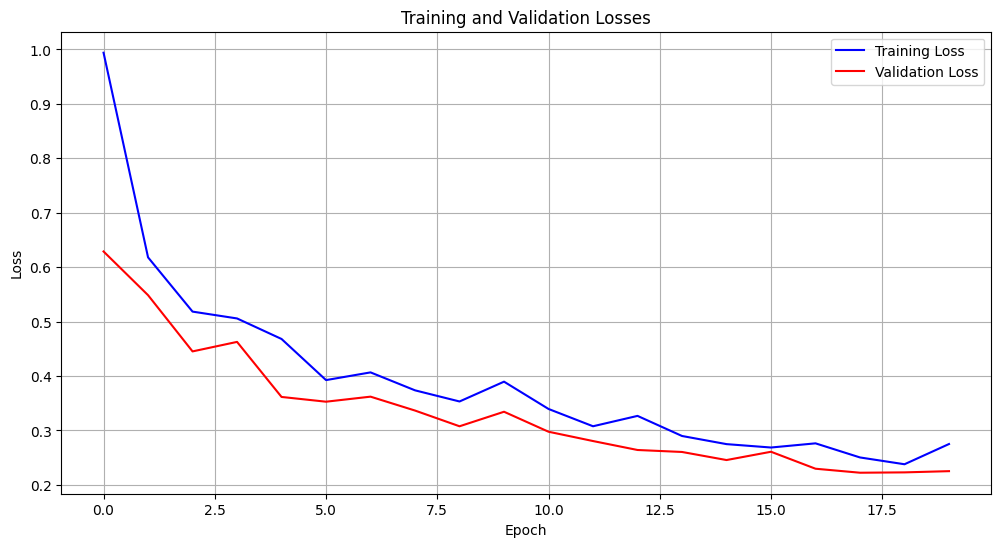

In [15]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot the losses
plot_losses(train_losses, val_losses)

In [16]:
import numpy as np
import torch
import torch.nn as nn

# Evaluation function for test set
def evaluate_model(test_loader, model, pre_conv, device, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits

    test_loss = 0.0
    test_dice = 0.0
    test_f1 = 0.0
    correct_test = 0
    total_test = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = forward(inputs)

            # Apply sigmoid to the outputs for binary classification
            outputs_sigmoid = torch.sigmoid(outputs)

            # Compute loss
            loss = bce_loss(outputs_sigmoid, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate Dice and F1 scores
            dice_score = dice_coefficient(outputs_sigmoid, labels, threshold)
            f1 = f1_score(outputs_sigmoid, labels, threshold)

            test_dice += dice_score.item() * inputs.size(0)
            test_f1 += f1.item() * inputs.size(0)

            # Collect predictions and true labels for accuracy calculation
            preds = (outputs_sigmoid > threshold).cpu().numpy().astype(int).flatten()
            labels = labels.cpu().numpy().astype(int).flatten()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate average metrics
    test_loss /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    test_f1 /= len(test_loader.dataset)

    # Compute accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    # Print the evaluation report
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Dice Score: {test_dice:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Example usage
evaluate_model(test_loader, model, pre_conv, device, threshold=0.5)


Test Loss: 0.6287
Test Dice Score: 0.8970
Test F1 Score: 0.8970
Test Accuracy: 0.9530


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToPILImage

def visualize_random_images(test_loader, model, pre_conv, device, num_images=5, threshold=0.5):
    model.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    to_pil = ToPILImage()

    # Get all indices from the test_loader
    indices = list(range(len(test_loader)))
    selected_indices = random.sample(indices, num_images)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i in selected_indices:
                index = selected_indices.index(i)

                inputs, labels = inputs.to(device), labels.to(device)

                # Get model predictions
                outputs = forward(inputs)

                # Convert tensors to numpy arrays for visualization
                inputs_np = inputs.cpu().numpy()
                labels_np = labels.cpu().numpy().squeeze(1)  # Remove channel dimension
                outputs_np = torch.sigmoid(outputs).cpu().numpy().squeeze(1)  # Remove channel dimension

                # Convert single channel images to RGB-like format for visualization
                if inputs_np.shape[1] == 1:
                    inputs_np = np.tile(inputs_np, (1, 3, 1, 1))  # Convert single channel to RGB-like format
                elif inputs_np.shape[1] > 3:
                    inputs_np = inputs_np[:, :3, :, :]  # Use only the first 3 channels if more than 3

                inputs_np = np.transpose(inputs_np, (0, 2, 3, 1))  # CHW to HWC

                # Normalize images
                inputs_np = (inputs_np[0] - np.min(inputs_np[0])) / (np.max(inputs_np[0]) - np.min(inputs_np[0]))

                # Ensure masks are binary (0 and 1)
                labels_np = (labels_np[0] > 0.5).astype(np.float32)
                outputs_np = (outputs_np[0] > 0.5).astype(np.float32)

                # Plot image, ground truth, and prediction
                axes[index, 0].imshow(inputs_np)
                axes[index, 0].set_title("Test Image")
                axes[index, 0].axis('off')

                axes[index, 1].imshow(labels_np, cmap='gray', vmin=0, vmax=1)
                axes[index, 1].set_title("Ground Truth Mask")
                axes[index, 1].axis('off')

                axes[index, 2].imshow(outputs_np, cmap='gray', vmin=0, vmax=1)
                axes[index, 2].set_title("Predicted Mask")
                axes[index, 2].axis('off')

    plt.tight_layout()
    plt.show()


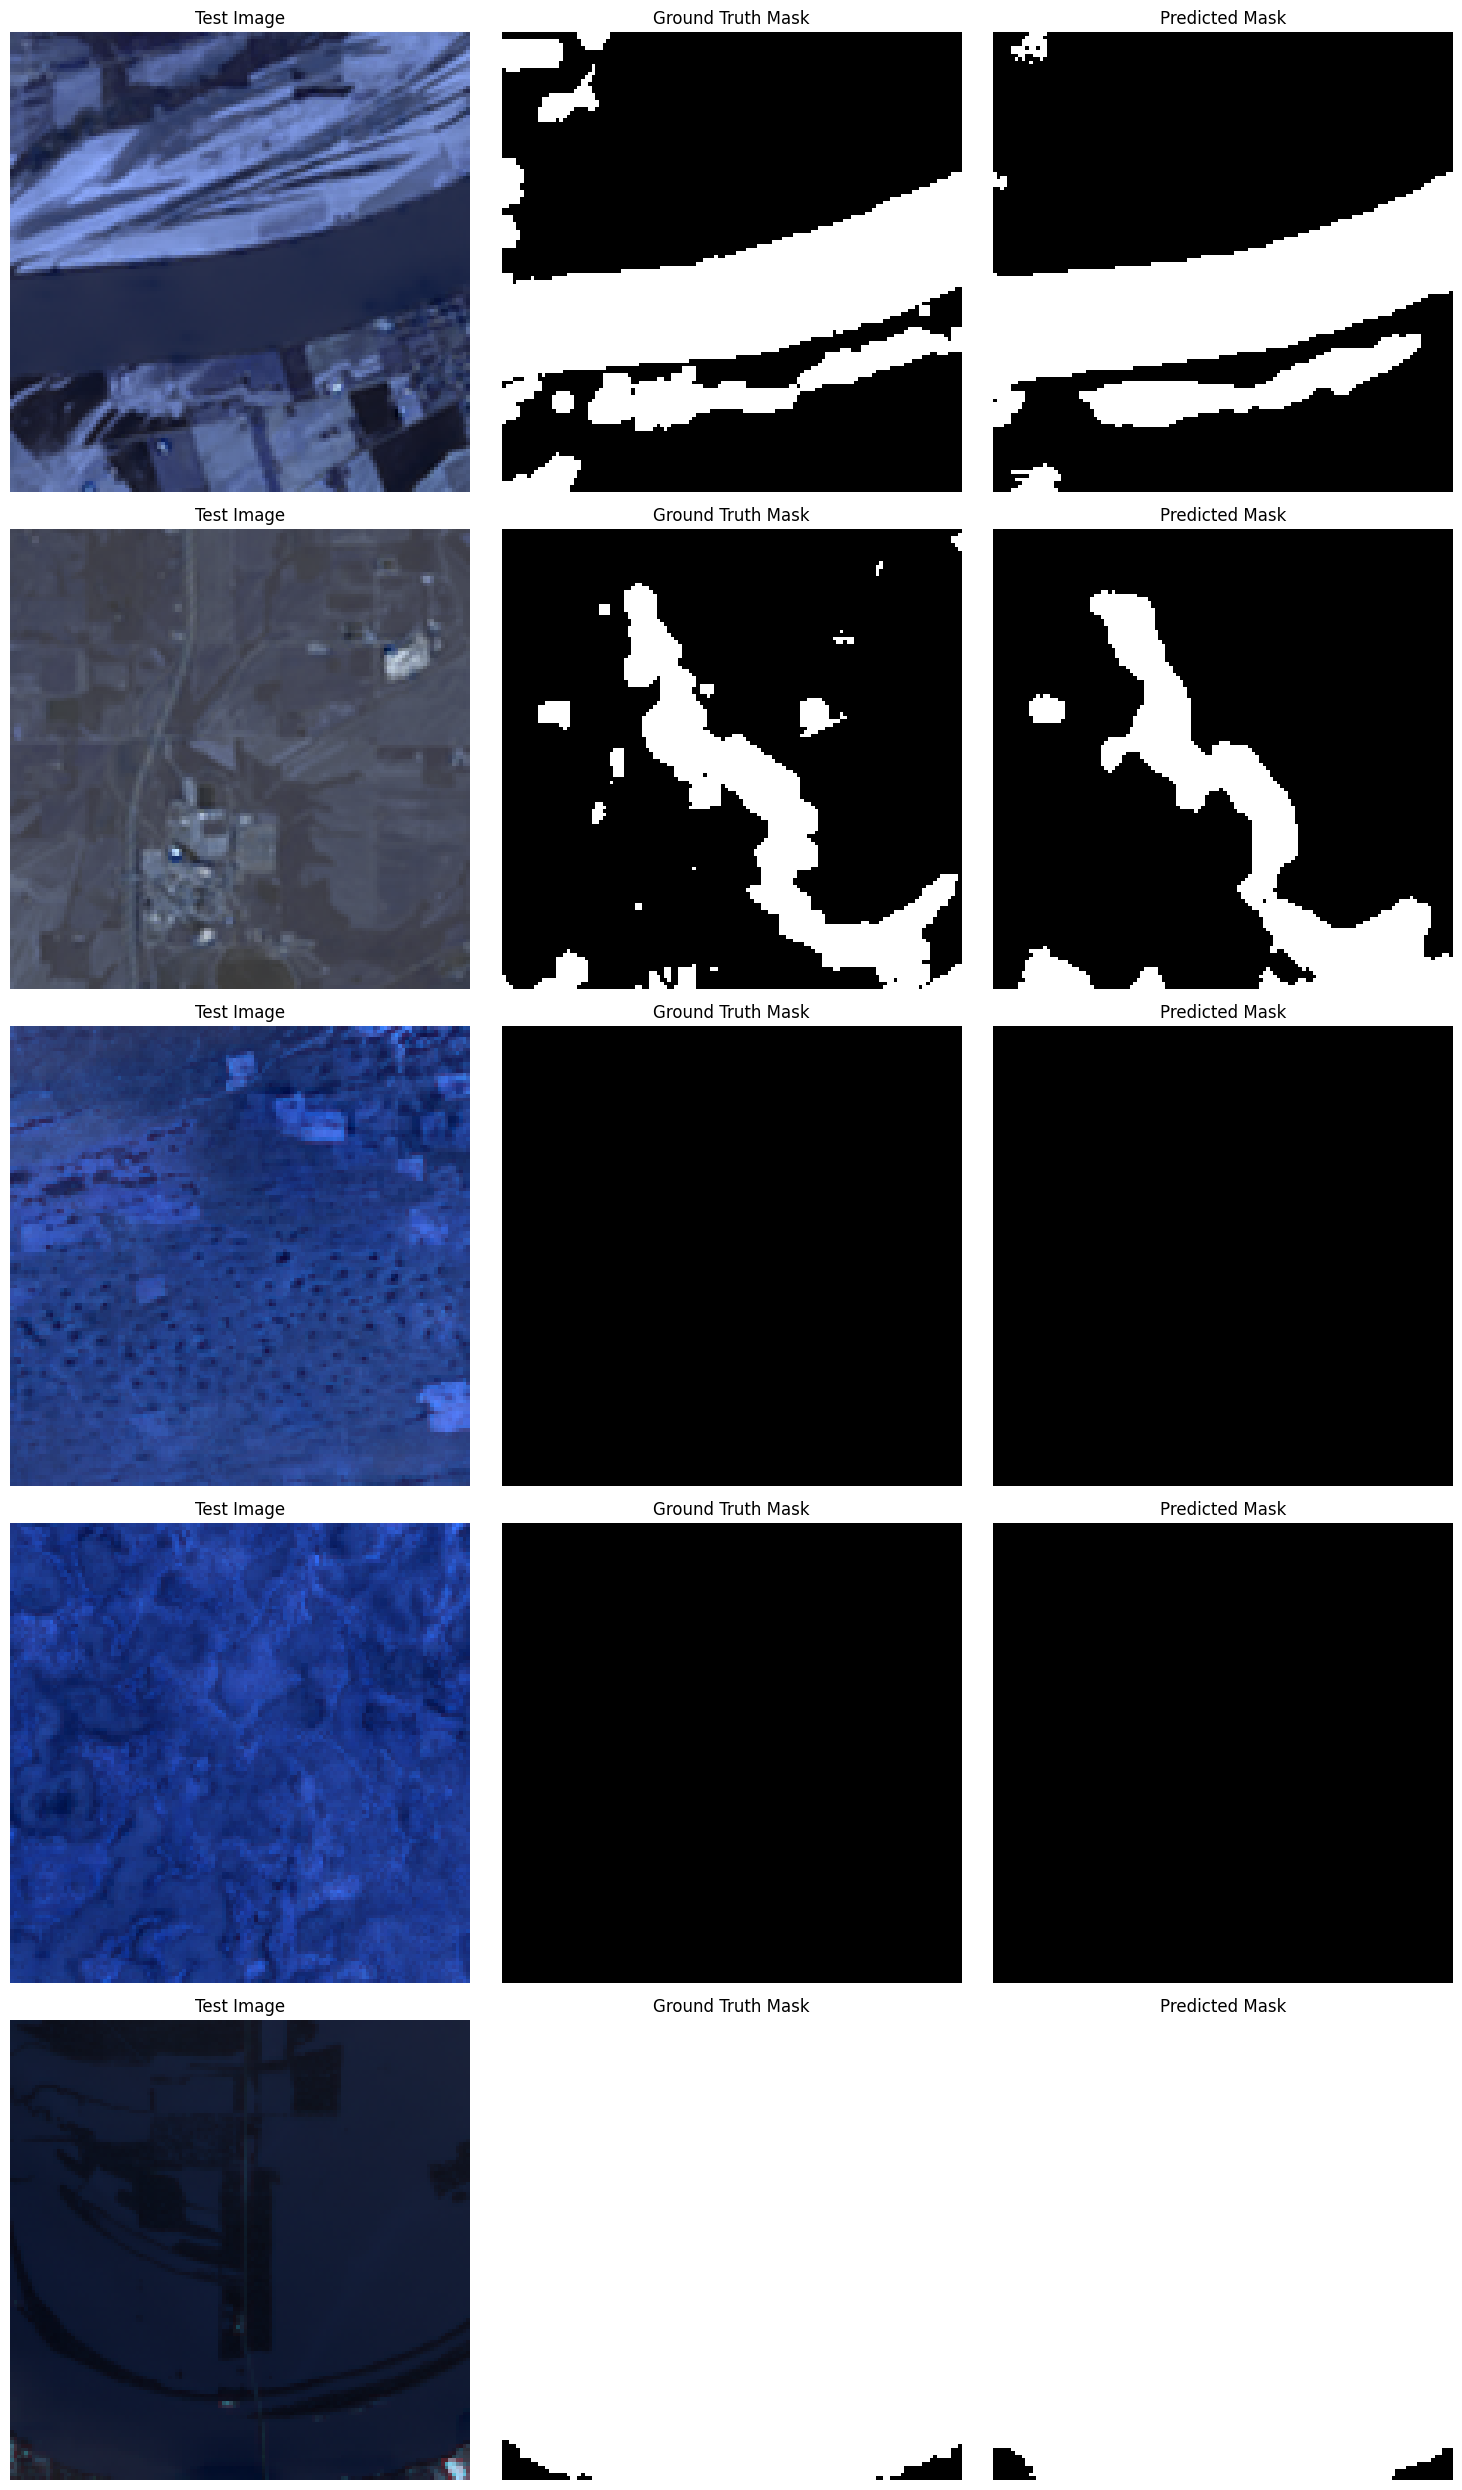

In [20]:
visualize_random_images(test_loader, model, pre_conv, device, num_images=5, threshold=0.7)

In [21]:
# Save the model and pre_conv layers
torch.save({
    'pre_conv_state_dict': pre_conv.state_dict(),
    'model_state_dict': model.state_dict(),
}, 'unet_model.pth')

print("Model saved successfully!")

Model saved successfully!
